## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [11]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [12]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

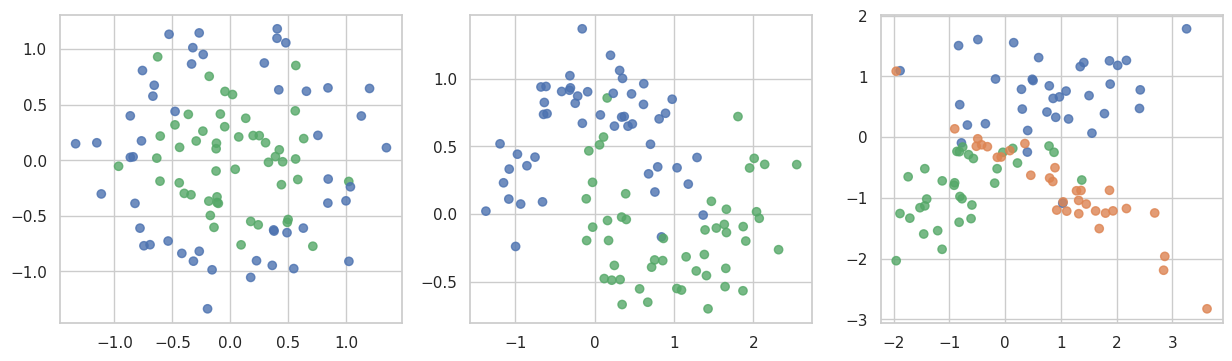

In [13]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

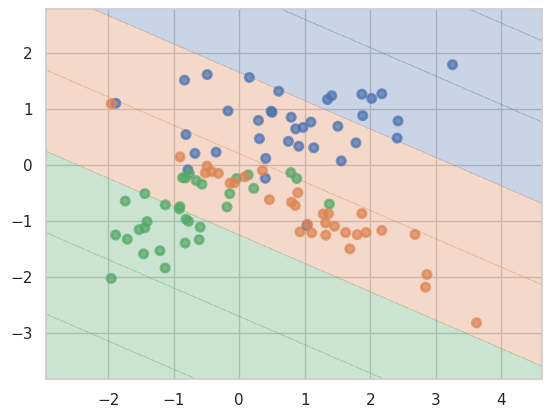

In [14]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

__Ответ:__

=== Circles ===
Train accuracy: 1.0000
Test accuracy: 0.7000
Разница (train - test): 0.3000
Глубина дерева: 6

=== Moons ===
Train accuracy: 1.0000
Test accuracy: 0.9333
Разница (train - test): 0.0667
Глубина дерева: 6

=== 3-Class Classification ===
Train accuracy: 1.0000
Test accuracy: 0.6667
Разница (train - test): 0.3333
Глубина дерева: 6



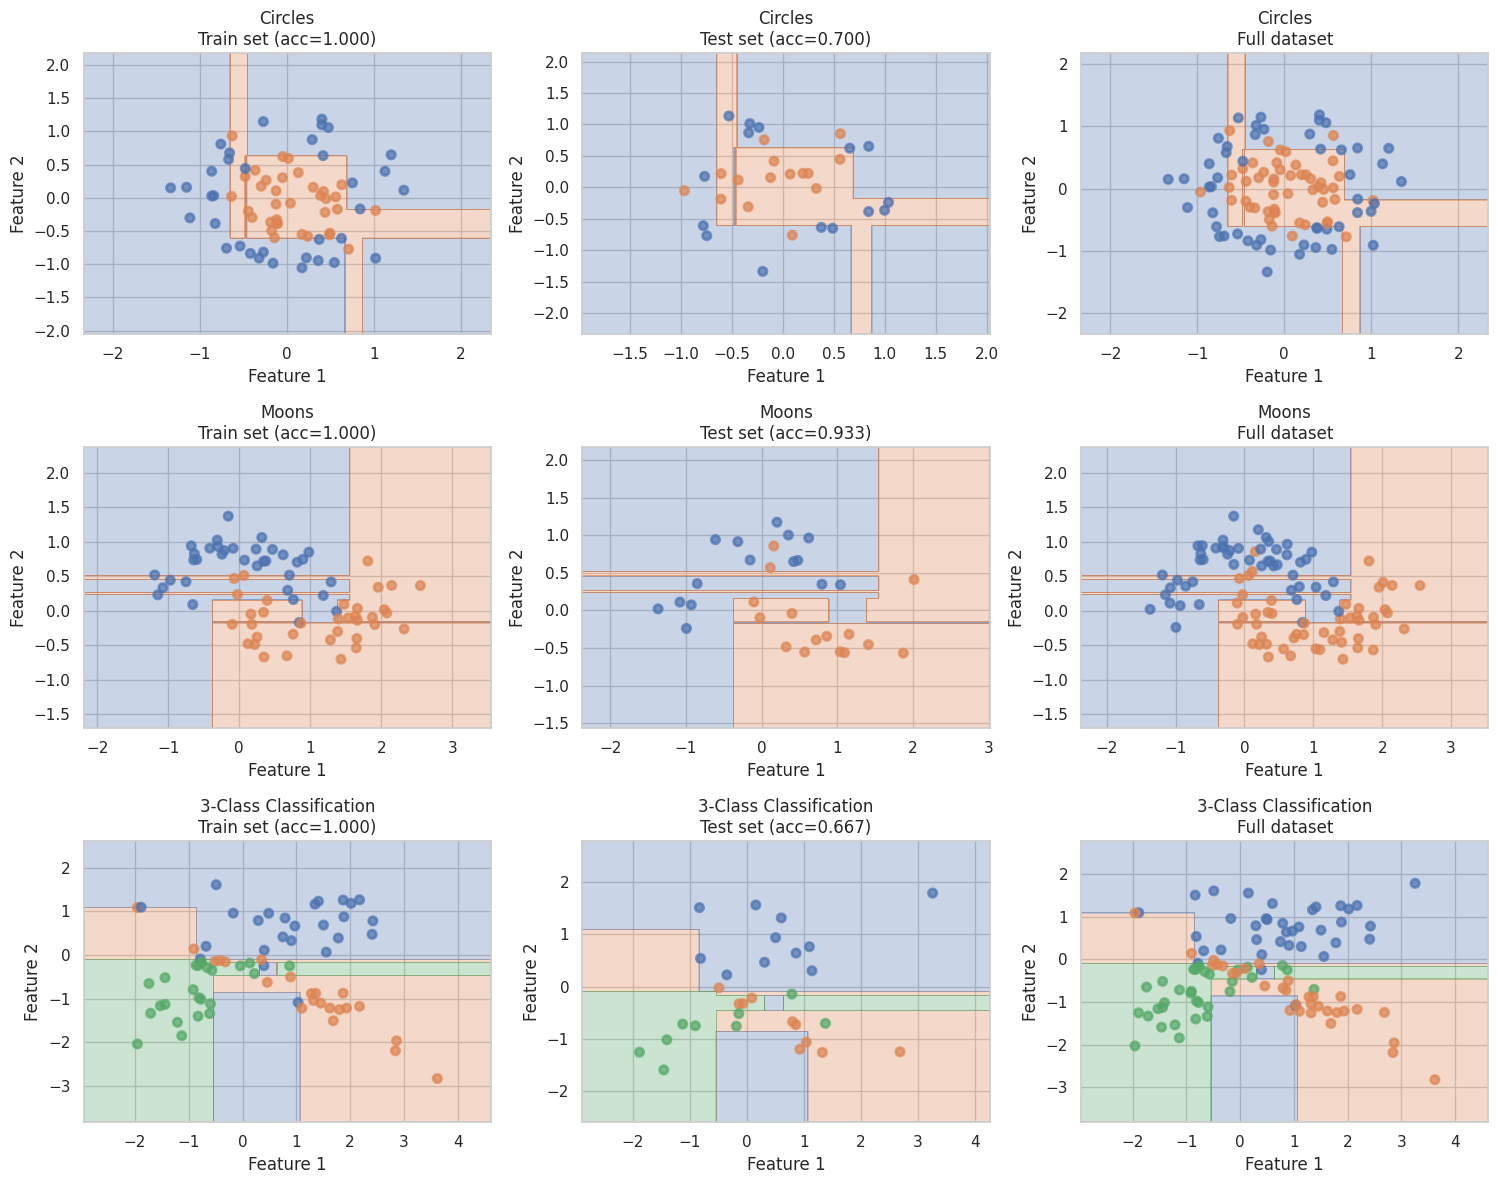

In [15]:
# Создаем датасеты
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

datasets_names = ["Circles", "Moons", "3-Class Classification"]

# Создание цветовой палитры
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)



# Функция для визуализации разделяющей поверхности
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    return cs

fig, axes = plt.subplots(len(datasets), 3, figsize=(15, 12))

# Анализируем каждый датасет
for i, ((X, y), dataset_name) in enumerate(zip(datasets, datasets_names)):
    # 1. Разделяем на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 2. Обучаем решающее дерево с параметрами по умолчанию
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # 3. Считаем accuracy
    train_accuracy = clf.score(X_train, y_train)
    test_accuracy = clf.score(X_test, y_test)

    print(f"=== {dataset_name} ===")
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Разница (train - test): {train_accuracy - test_accuracy:.4f}")
    print(f"Глубина дерева: {clf.get_depth()}")
    print()

    # 4. Визуализируем разделяющие поверхности

    # а) На обучающей выборке
    ax = axes[i, 0]
    plt.sca(ax)
    cs = plot_surface(clf, X_train, y_train)
    ax.set_title(f'{dataset_name}\nTrain set (acc={train_accuracy:.3f})')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    # б) На тестовой выборке
    ax = axes[i, 1]
    plt.sca(ax)
    cs = plot_surface(clf, X_test, y_test)
    ax.set_title(f'{dataset_name}\nTest set (acc={test_accuracy:.3f})')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    # в) На всей выборке
    ax = axes[i, 2]
    plt.sca(ax)
    cs = plot_surface(clf, X, y)
    ax.set_title(f'{dataset_name}\nFull dataset')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()


__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

**Ответ:**

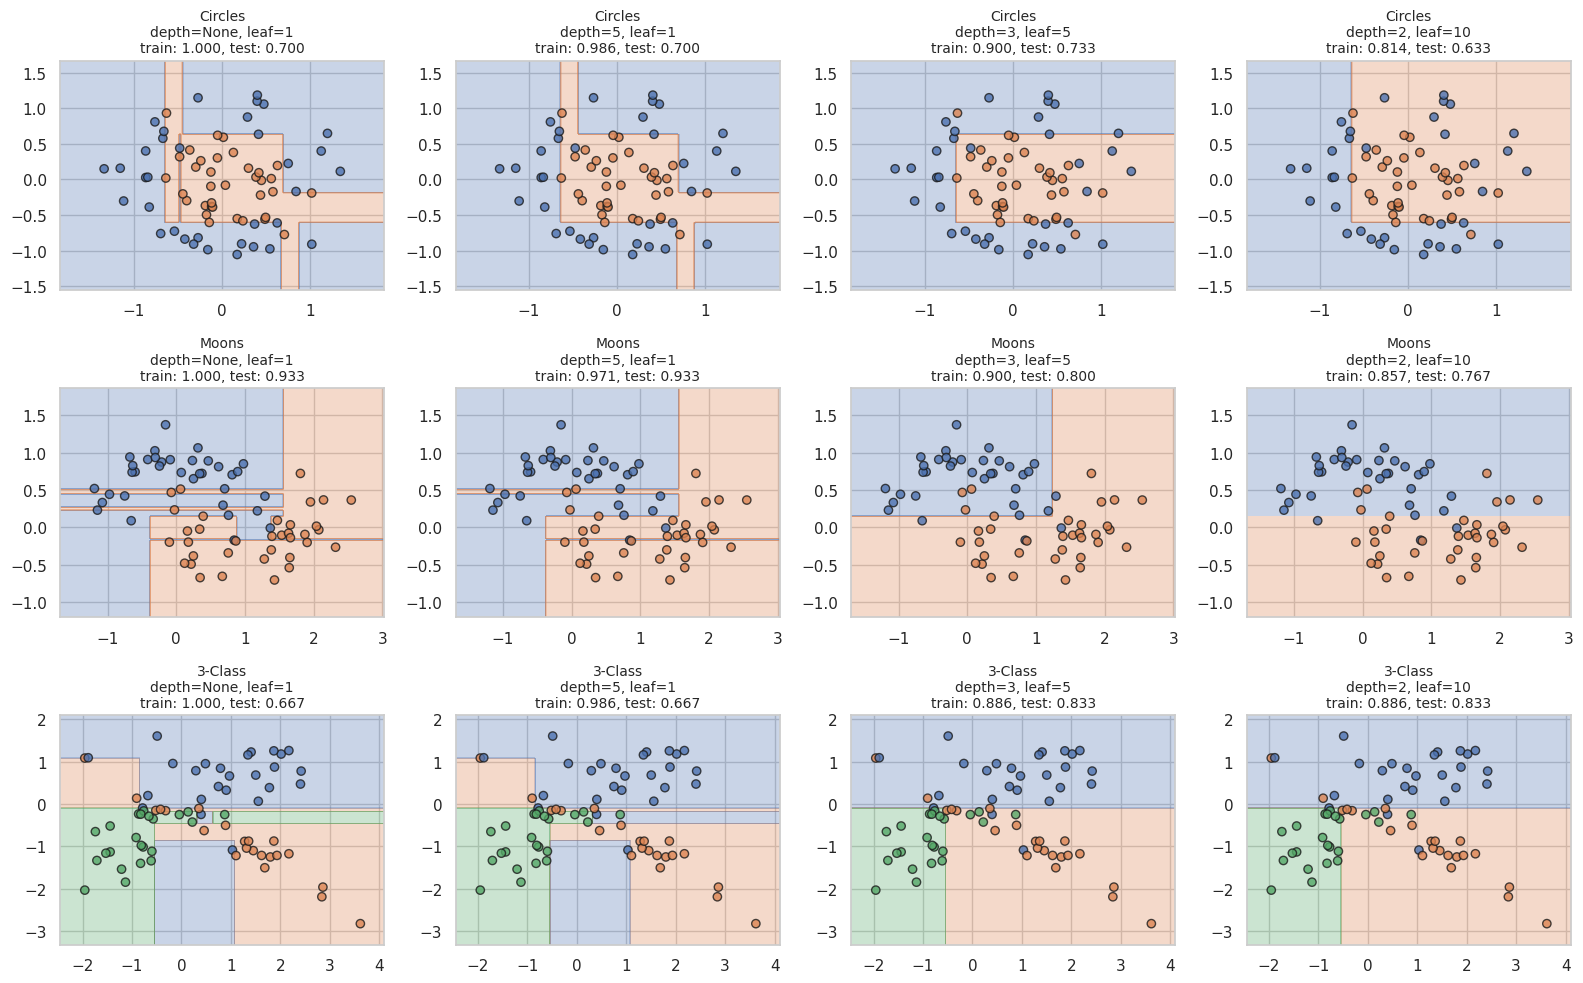

In [16]:
# Создаем датасеты
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2,
                        class_sep=.8, random_state=3, n_redundant=0)
]

datasets_names = ["Circles", "Moons", "3-Class"]

# Функция для визуализации
def plot_surface(clf, X, y, ax):
    plot_step = 0.02
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', alpha=0.8)

# Фиксированные разбиения
splits = [train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
          for X, y in datasets]

# Анализ параметров регуляризации
params_to_test = [
    {'max_depth': None, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 5},
    {'max_depth': 2, 'min_samples_leaf': 10}
]

fig, axes = plt.subplots(len(datasets), len(params_to_test), figsize=(16, 10))

for i, (dataset_name, (X_train, X_test, y_train, y_test)) in enumerate(zip(datasets_names, splits)):
    for j, params in enumerate(params_to_test):
        ax = axes[i, j]

        # Обучаем модель
        clf = DecisionTreeClassifier(**params, random_state=42)
        clf.fit(X_train, y_train)

        # Считаем accuracy
        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        # Визуализируем
        plot_surface(clf, X_train, y_train, ax)

        title = f"{dataset_name}\n"
        title += f"depth={params['max_depth'] or 'None'}, leaf={params['min_samples_leaf']}\n"
        title += f"train: {train_acc:.3f}, test: {test_acc:.3f}"
        ax.set_title(title, fontsize=10)

plt.tight_layout()
plt.show()

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [21]:
# Загружаем датасет mushrooms
# В UCI ML репозитории он доступен по ссылке:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Названия колонок согласно описанию датасета
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Читаем данные
df = pd.read_csv(url, header=None, names=column_names)

print("Первые 5 строк датасета:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")
print(f"\nПропущенные значения: {df.isnull().sum().sum()}")

# Проверяем распределение целевой переменной
print("\nРаспределение целевой переменной (class):")
print(df['class'].value_counts())
print(f"\nСоотношение edible(e):poisonous(p) = {df['class'].value_counts(normalize=True).round(3).to_dict()}")

# Создаем копию датасета для кодирования
df_encoded = df.copy()

# Применяем LabelEncoder к каждому столбцу
label_encoders = {}
for column in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("\nПервые 5 строк после кодирования:")
print(df_encoded.head())

# Разделяем на признаки и целевую переменную
X = df_encoded.drop('class', axis=1)  # все колонки кроме 'class'
y = df_encoded['class']  # целевая переменная

print(f"\nПризнаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

# Разделяем данные на обучающую и тестовую выборки (50/50)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"Обучающая выборка: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Тестовая выборка: X_test={X_test.shape}, y_test={y_test.shape}")

# Обучаем решающее дерево
print("\n" + "="*60)
print("Обучение решающего дерева...")
print("="*60)

# Попробуем несколько значений max_depth для нахождения оптимального
results = []

for max_depth in [3, 5, 7, 10, None]:
    # Создаем и обучаем модель
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=42,
        criterion='gini'
    )
    clf.fit(X_train, y_train)

    # Делаем предсказания
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Вычисляем accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Сохраняем результаты
    results.append({
        'max_depth': max_depth,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'n_leaves': clf.get_n_leaves(),
        'tree_depth': clf.get_depth()
    })

    print(f"max_depth={max_depth if max_depth else 'None':5} | "
          f"Train Accuracy: {train_accuracy:.4f} | "
          f"Test Accuracy: {test_accuracy:.4f} | "
          f"Листьев: {clf.get_n_leaves():3} | "
          f"Глубина: {clf.get_depth():2}")

# Находим модель с лучшей точностью на тесте
best_result = max(results, key=lambda x: x['test_accuracy'])
print("\n" + "="*60)
print(f"ЛУЧШАЯ МОДЕЛЬ: max_depth={best_result['max_depth']}")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"Train Accuracy: {best_result['train_accuracy']:.4f}")
print("="*60)

# Обучаем финальную модель с оптимальными параметрами
final_clf = DecisionTreeClassifier(
    max_depth=best_result['max_depth'],
    random_state=42
)
final_clf.fit(X_train, y_train)

# Итоговые предсказания и accuracy
y_test_pred = final_clf.predict(X_test)
final_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nИтоговый результат:")
print(f"Accuracy на тестовой выборке: {final_accuracy:.4f}")
print(f"Точность (precision) на тестовой выборке: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Глубина дерева: {final_clf.get_depth()}")
print(f"Количество листьев: {final_clf.get_n_leaves()}")

# Визуализируем дерево (если оно не слишком большое)
if best_result['max_depth'] <= 5:
    plt.figure(figsize=(20, 10))
    plot_tree(final_clf,
              feature_names=X.columns,
              class_names=['edible', 'poisonous'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f"Решающее дерево для классификации грибов (max_depth={best_result['max_depth']})")
    plt.tight_layout()
    plt.show()
else:
    print("\nДерево слишком большое для визуализации.")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Проверяем, есть ли признаки с нулевой важностью
zero_importance_features = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance_features) > 0:
    print(f"\nПризнаков с нулевой важностью: {len(zero_importance_features)}")
    print("Эти признаки можно удалить без потери точности.")

# Обучение дерева с ограниченной глубиной для визуализации
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Оценка модели
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.4f}")
print(f"Глубина дерева: {clf.get_depth()}")
print(f"Количество листьев: {clf.get_n_leaves()}")

Первые 5 строк датасета:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w        

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

In [24]:
def load_datasets():
    datasets_raw = {}
    datasets_processed = {}

    # 1. Mushrooms
    print("Загружаем mushrooms...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    mushroom_columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                        'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                        'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                        'stalk-surface-below-ring', 'stalk-color-above-ring',
                        'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                        'ring-type', 'spore-print-color', 'population', 'habitat']
    mushrooms = pd.read_csv(url, header=None, names=mushroom_columns)
    datasets_raw['mushrooms'] = mushrooms
    # Для mushrooms целевая переменная в первом столбце
    datasets_processed['mushrooms'] = (mushrooms.iloc[:, 1:], mushrooms.iloc[:, 0])

    # 2. Tic-tac-toe
    print("Загружаем tic-tac-toe...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
    tic_columns = ['top-left', 'top-middle', 'top-right',
                   'middle-left', 'middle-middle', 'middle-right',
                   'bottom-left', 'bottom-middle', 'bottom-right', 'class']
    tic_tac_toe = pd.read_csv(url, header=None, names=tic_columns)
    datasets_raw['tic-tac-toe'] = tic_tac_toe
    datasets_processed['tic-tac-toe'] = (tic_tac_toe.iloc[:, :-1], tic_tac_toe.iloc[:, -1])

    # 3. Cars
    print("Загружаем cars...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
    car_columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    cars = pd.read_csv(url, header=None, names=car_columns)
    # Преобразуем классы для cars: unacc, acc -> 0; good, vgood -> 1
    cars['class'] = cars['class'].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    datasets_raw['cars'] = cars
    datasets_processed['cars'] = (cars.iloc[:, :-1], cars.iloc[:, -1])

    # 4. Nursery
    print("Загружаем nursery...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
    nursery_columns = ['parents', 'has_nurs', 'form', 'children', 'housing',
                       'finance', 'social', 'health', 'class']
    nursery = pd.read_csv(url, header=None, names=nursery_columns)
    # Преобразуем классы для nursery
    class_mapping = {'not_recom': 0, 'recommend': 0, 'very_recom': 1,
                     'priority': 1, 'spec_prior': 1}
    nursery['class'] = nursery['class'].map(class_mapping)
    datasets_raw['nursery'] = nursery
    datasets_processed['nursery'] = (nursery.iloc[:, :-1], nursery.iloc[:, -1])

    # 5. User Knowledge Modeling
    print("Загружаем knowledge...")
    try:
        # Пробуем загрузить как CSV (более надежный способ)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Knowledge%20Modeling%20Data%20Set.xlsx"
        # Скачиваем и сохраняем локально
        import requests
        response = requests.get(url)
        with open('knowledge.xlsx', 'wb') as f:
            f.write(response.content)

        # Читаем Excel файл
        knowledge = pd.read_excel('knowledge.xlsx')

        # Проверяем структуру данных
        if 'UNS' in knowledge.columns:
            # Если есть столбец UNS (целевой)
            X_knowledge = knowledge.drop('UNS', axis=1)
            y_knowledge = knowledge['UNS']
        else:
            # Предполагаем, что последний столбец - целевой
            X_knowledge = knowledge.iloc[:, :-1]
            y_knowledge = knowledge.iloc[:, -1]

        # Кодируем целевую переменную
        le_y = LabelEncoder()
        y_knowledge_encoded = le_y.fit_transform(y_knowledge.astype(str))

        datasets_raw['knowledge'] = knowledge
        datasets_processed['knowledge'] = (X_knowledge, pd.Series(y_knowledge_encoded))

    except Exception as e:
        print(f"Не удалось загрузить knowledge dataset: {e}")
        print("Создаем тестовый датасет для демонстрации...")
        # Создаем тестовый датасет
        np.random.seed(42)
        n_samples = 200
        X_test = pd.DataFrame({
            'feature1': np.random.randn(n_samples),
            'feature2': np.random.randn(n_samples),
            'feature3': np.random.randn(n_samples),
            'feature4': np.random.randn(n_samples),
            'feature5': np.random.randn(n_samples)
        })
        y_test = pd.Series(np.random.choice(['very_low', 'Low', 'Middle', 'High'], n_samples))

        datasets_raw['knowledge'] = pd.concat([X_test, y_test], axis=1)
        datasets_processed['knowledge'] = (X_test, y_test)

    print("\nЗагрузка завершена!")
    return datasets_raw, datasets_processed

def prepare_datasets(datasets_processed):
    """Подготовка датасетов: кодирование признаков разными способами"""
    datasets_label_encoded = {}
    datasets_onehot = {}

    for name, (X, y) in datasets_processed.items():
        print(f"Обрабатываем {name}...")

        # 1. Кодируем целевую переменную (если еще не закодирована)
        if not np.issubdtype(y.dtype, np.number):
            le_y = LabelEncoder()
            y_encoded = le_y.fit_transform(y)
        else:
            y_encoded = y.values

        # 2. Label Encoding для признаков (Метод 1 и 2)
        X_label_encoded = X.copy()
        label_encoders = {}

        for col in X.columns:
            if X[col].dtype == 'object' or isinstance(X[col].iloc[0] if len(X) > 0 else '', str):
                le = LabelEncoder()
                X_label_encoded[col] = le.fit_transform(X[col].astype(str))
                label_encoders[col] = le
            else:
                # Если признак уже числовой, оставляем как есть
                X_label_encoded[col] = X[col].values

        datasets_label_encoded[name] = (X_label_encoded, y_encoded)

        # 3. One-Hot Encoding для признаков (Метод 3)
        X_onehot = X.copy()

        # Сначала преобразуем все в строки для OneHotEncoder
        X_str = X.astype(str)

        # Применяем OneHotEncoder
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_onehot_encoded = ohe.fit_transform(X_str)

        datasets_onehot[name] = (X_onehot_encoded, y_encoded)

    return datasets_label_encoded, datasets_onehot

def evaluate_models(datasets_label, datasets_onehot):
    """Оценка моделей с кросс-валидацией"""
    results = {}
    scorer = make_scorer(accuracy_score)

    for name in datasets_label.keys():
        print(f"\nОцениваем модели для {name}...")

        X_label, y_label = datasets_label[name]
        X_onehot, y_onehot = datasets_onehot[name]

        # Проверяем, что y одинаковые
        assert np.array_equal(y_label, y_onehot), f"Целевые переменные не совпадают для {name}"

        # 1. DecisionTreeClassifier с вещественными признаками (после LabelEncoder)
        dt_real = DecisionTreeClassifier(random_state=42)
        scores_real = cross_val_score(dt_real, X_label, y_label, cv=10, scoring=scorer)

        # 2. DecisionTreeClassifier с категориальными признаками
        # В sklearn нет явного указания категориальных признаков, используем ту же предобработку
        dt_cat = DecisionTreeClassifier(random_state=42, criterion='entropy')
        scores_cat = cross_val_score(dt_cat, X_label, y_label, cv=10, scoring=scorer)

        # 3. DecisionTreeClassifier с вещественными признаками + one-hot-encoding
        dt_onehot = DecisionTreeClassifier(random_state=42, max_depth=10)  # Ограничиваем глубину
        scores_onehot = cross_val_score(dt_onehot, X_onehot, y_onehot, cv=10, scoring=scorer)

        # Сохраняем результаты
        results[name] = {
            'Real_features': np.mean(scores_real),
            'Real_std': np.std(scores_real),
            'Categorical_features': np.mean(scores_cat),
            'Categorical_std': np.std(scores_cat),
            'Real+OneHot': np.mean(scores_onehot),
            'OneHot_std': np.std(scores_onehot),
            'samples': X_label.shape[0],
            'features': X_label.shape[1],
            'features_onehot': X_onehot.shape[1]  # Размерность после OHE
        }

        print(f"  Real: {np.mean(scores_real):.4f} (+/- {np.std(scores_real):.4f})")
        print(f"  Categorical: {np.mean(scores_cat):.4f} (+/- {np.std(scores_cat):.4f})")
        print(f"  OneHot: {np.mean(scores_onehot):.4f} (+/- {np.std(scores_onehot):.4f})")

    return results

# ========== ОСНОВНОЙ КОД ==========
print("="*60)
print("СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ ДЛЯ DECISION TREE")
print("="*60)

# 1. Загрузка данных
datasets_raw, datasets_processed = load_datasets()

# 2. Подготовка данных
print("\n" + "="*60)
print("ПОДГОТОВКА ДАННЫХ")
print("="*60)
datasets_label, datasets_onehot = prepare_datasets(datasets_processed)

# 3. Оценка моделей
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛЕЙ (кросс-валидация cv=10)")
print("="*60)
results = evaluate_models(datasets_label, datasets_onehot)

# 4. Создание итоговой таблицы
print("\n" + "="*60)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*60)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T

# Форматируем вывод
display_df = pd.DataFrame({
    'Samples': results_df['samples'],
    'Features': results_df['features'],
    'Features (OHE)': results_df['features_onehot'],
    'Real (accuracy)': results_df['Real_features'].apply(lambda x: f"{x:.4f}"),
    'Categorical (accuracy)': results_df['Categorical_features'].apply(lambda x: f"{x:.4f}"),
    'Real+OneHot (accuracy)': results_df['Real+OneHot'].apply(lambda x: f"{x:.4f}")
})

print(display_df.to_string())

# 6. Анализ результатов
print("\n" + ""*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print(""*60)

print("\nЛучший метод для каждого датасета:")
for name in datasets_names:
    real_acc = results[name]['Real_features']
    cat_acc = results[name]['Categorical_features']
    onehot_acc = results[name]['Real+OneHot']

    best_acc = max(real_acc, cat_acc, onehot_acc)
    best_method = ''

    if best_acc == real_acc:
        best_method = 'Real'
    elif best_acc == cat_acc:
        best_method = 'Categorical'
    else:
        best_method = 'OneHot'

    print(f"  {name:15} → {best_method:12} (accuracy = {best_acc:.4f})")

print("\nСредняя accuracy по всем датасетам:")
print(f"  Real:        {np.mean(real_acc):.4f}")
print(f"  Categorical: {np.mean(cat_acc):.4f}")
print(f"  OneHot:      {np.mean(onehot_acc):.4f}")

# 7. Сохранение результатов
results_df.to_csv('decision_tree_encoding_comparison.csv')
print(f"\nРезультаты сохранены в файл: decision_tree_encoding_comparison.csv")

СРАВНЕНИЕ МЕТОДОВ КОДИРОВАНИЯ ДЛЯ DECISION TREE
Загружаем mushrooms...
Загружаем tic-tac-toe...
Загружаем cars...
Загружаем nursery...
Загружаем knowledge...
Не удалось загрузить knowledge dataset: Excel file format cannot be determined, you must specify an engine manually.
Создаем тестовый датасет для демонстрации...

Загрузка завершена!

ПОДГОТОВКА ДАННЫХ
Обрабатываем mushrooms...
Обрабатываем tic-tac-toe...
Обрабатываем cars...
Обрабатываем nursery...
Обрабатываем knowledge...

ОЦЕНКА МОДЕЛЕЙ (кросс-валидация cv=10)

Оцениваем модели для mushrooms...
  Real: 0.9604 (+/- 0.0949)
  Categorical: 0.9604 (+/- 0.0949)
  OneHot: 0.9564 (+/- 0.0970)

Оцениваем модели для tic-tac-toe...
  Real: 0.7717 (+/- 0.1125)
  Categorical: 0.7862 (+/- 0.1008)
  OneHot: 0.8071 (+/- 0.1491)

Оцениваем модели для cars...
  Real: 0.9427 (+/- 0.0317)
  Categorical: 0.9334 (+/- 0.0390)
  OneHot: 0.8203 (+/- 0.2476)

Оцениваем модели для nursery...
  Real: 0.9997 (+/- 0.0006)
  Categorical: 0.9997 (+/- 0.0006

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

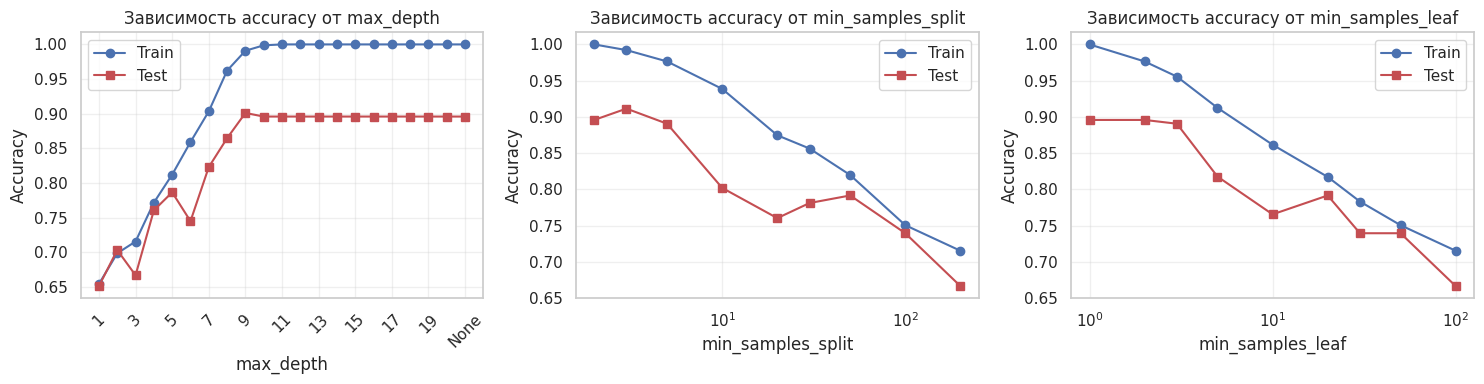

Оптимальные параметры:
max_depth: 9
min_samples_split: 3
min_samples_leaf: 1


In [25]:
# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
columns = ['top-left', 'top-middle', 'top-right',
           'middle-left', 'middle-middle', 'middle-right',
           'bottom-left', 'bottom-middle', 'bottom-right', 'class']

df = pd.read_csv(url, header=None, names=columns)

# Подготовка данных
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_encoded = X.copy()
for col in X.columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 1. Анализ зависимости от max_depth
max_depths = list(range(1, 21)) + [None]
train_scores = []
test_scores = []
cv_scores = []

for max_depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
    cv_scores.append(np.mean(cross_val_score(clf, X_encoded, y_encoded, cv=5)))

# График для max_depth
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
x_labels = [str(d) if d is not None else "None" for d in max_depths]
x_positions = np.arange(len(max_depths))
plt.plot(x_positions, train_scores, 'b-', marker='o', label='Train')
plt.plot(x_positions, test_scores, 'r-', marker='s', label='Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от max_depth')
plt.xticks(x_positions[::2], x_labels[::2], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Анализ зависимости от min_samples_split
min_samples_split_values = [2, 3, 5, 10, 20, 30, 50, 100, 200]
train_scores_split = []
test_scores_split = []

for min_split in min_samples_split_values:
    clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    clf.fit(X_train, y_train)
    train_scores_split.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores_split.append(accuracy_score(y_test, clf.predict(X_test)))

plt.subplot(1, 3, 2)
plt.plot(min_samples_split_values, train_scores_split, 'b-', marker='o', label='Train')
plt.plot(min_samples_split_values, test_scores_split, 'r-', marker='s', label='Test')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_split')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Анализ зависимости от min_samples_leaf
min_samples_leaf_values = [1, 2, 3, 5, 10, 20, 30, 50, 100]
train_scores_leaf = []
test_scores_leaf = []

for min_leaf in min_samples_leaf_values:
    clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    clf.fit(X_train, y_train)
    train_scores_leaf.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores_leaf.append(accuracy_score(y_test, clf.predict(X_test)))

plt.subplot(1, 3, 3)
plt.plot(min_samples_leaf_values, train_scores_leaf, 'b-', marker='o', label='Train')
plt.plot(min_samples_leaf_values, test_scores_leaf, 'r-', marker='s', label='Test')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от min_samples_leaf')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оптимальные параметры
optimal_max_depth = max_depths[np.argmax(test_scores)]
optimal_split = min_samples_split_values[np.argmax(test_scores_split)]
optimal_leaf = min_samples_leaf_values[np.argmax(test_scores_leaf)]

print(f"Оптимальные параметры:")
print(f"max_depth: {optimal_max_depth}")
print(f"min_samples_split: {optimal_split}")
print(f"min_samples_leaf: {optimal_leaf}")

__2.4. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Загрузка данных...

Оценка моделей...
  Обрабатываем mushrooms...
  Обрабатываем tic-tac-toe...
  Обрабатываем cars...
  Обрабатываем nursery...

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА
             Label Encoding  Categorical  One-Hot Encoding
mushrooms            0.9604       0.9604            0.9564
tic-tac-toe          0.7717       0.7862            0.8071
cars                 0.9427       0.9334            0.8203
nursery              0.9997       0.9997            0.9998

АНАЛИЗ РЕЗУЛЬТАТОВ
mushrooms       → Лучший метод: Label Encoding       (accuracy = 0.9604)
tic-tac-toe     → Лучший метод: One-Hot Encoding     (accuracy = 0.8071)
cars            → Лучший метод: Label Encoding       (accuracy = 0.9427)
nursery         → Лучший метод: One-Hot Encoding     (accuracy = 0.9998)

Средний ранг методов по всем датасетам:
  Label Encoding       → средний ранг: 1.75
  One-Hot Encoding     → средний ранг: 2.00
  Categorical          → средний ранг: 2.25

СТАТИСТИЧЕСКИЙ АНАЛИЗ

Различия в accuracy между 

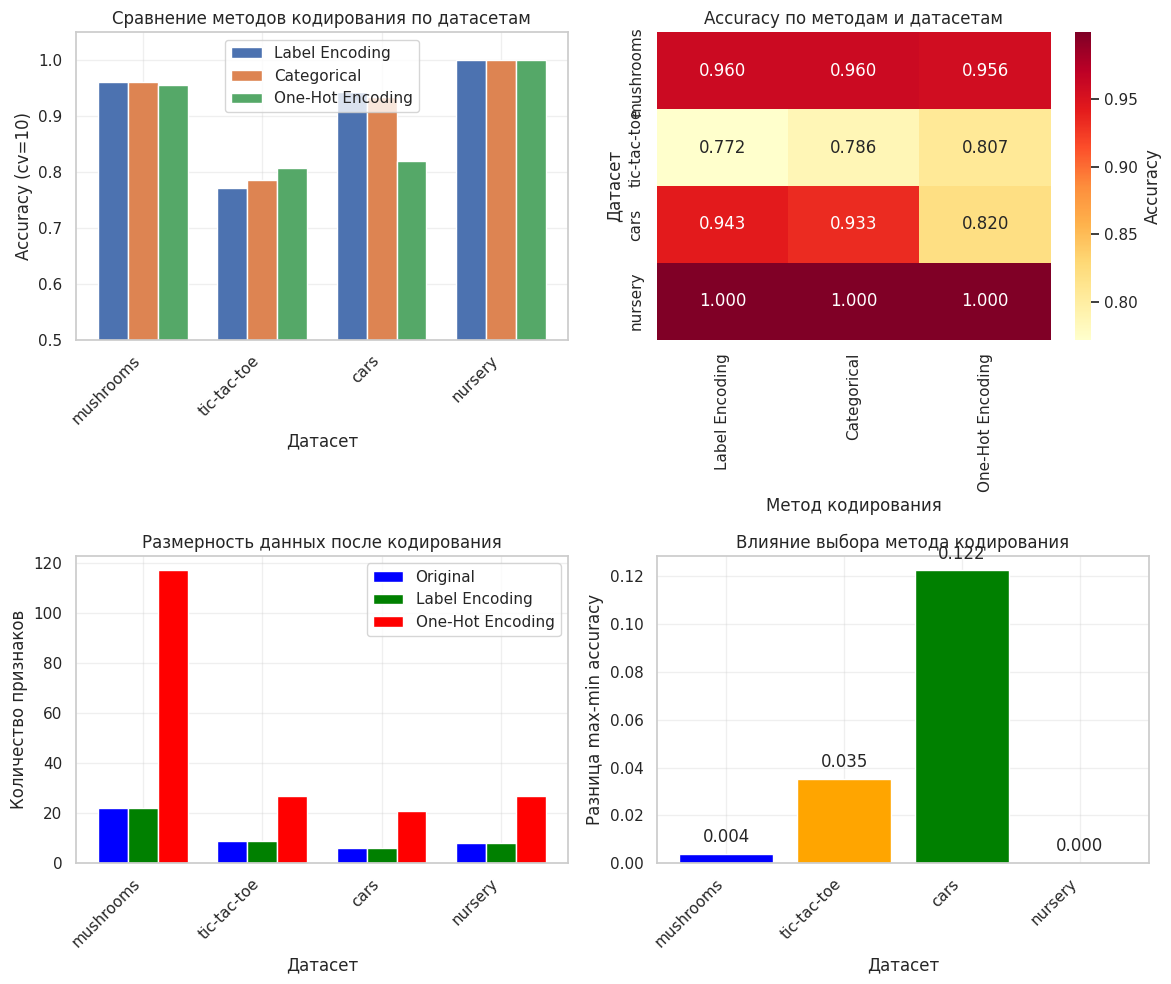


АНАЛИТИЧЕСКИЕ ВЫВОДЫ

1. РАНЖИРОВАНИЕ АЛГОРИТМОВ:
----------------------------------------

mushrooms:
  1. Label Encoding       = 0.9604
  2. Categorical          = 0.9604
  3. One-Hot Encoding     = 0.9564

tic-tac-toe:
  1. One-Hot Encoding     = 0.8071
  2. Categorical          = 0.7862
  3. Label Encoding       = 0.7717

cars:
  1. Label Encoding       = 0.9427
  2. Categorical          = 0.9334
  3. One-Hot Encoding     = 0.8203

nursery:
  1. One-Hot Encoding     = 0.9998
  2. Label Encoding       = 0.9997
  3. Categorical          = 0.9997


In [29]:
# Загрузка данных
print("Загрузка данных...")

# 1. Mushrooms
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_columns = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                    'stalk-surface-below-ring', 'stalk-color-above-ring',
                    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                    'ring-type', 'spore-print-color', 'population', 'habitat']
mushrooms = pd.read_csv(url, header=None, names=mushroom_columns)
X_mush = mushrooms.iloc[:, 1:]
y_mush = mushrooms.iloc[:, 0]

# 2. Tic-tac-toe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
tic_columns = ['top-left', 'top-middle', 'top-right',
               'middle-left', 'middle-middle', 'middle-right',
               'bottom-left', 'bottom-middle', 'bottom-right', 'class']
tic_tac_toe = pd.read_csv(url, header=None, names=tic_columns)
X_tic = tic_tac_toe.iloc[:, :-1]
y_tic = tic_tac_toe.iloc[:, -1]

# 3. Cars
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
car_columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
cars = pd.read_csv(url, header=None, names=car_columns)
cars['class'] = cars['class'].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
X_car = cars.iloc[:, :-1]
y_car = cars.iloc[:, -1]

# 4. Nursery
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
nursery_columns = ['parents', 'has_nurs', 'form', 'children', 'housing',
                   'finance', 'social', 'health', 'class']
nursery = pd.read_csv(url, header=None, names=nursery_columns)
class_mapping = {'not_recom': 0, 'recommend': 0, 'very_recom': 1,
                 'priority': 1, 'spec_prior': 1}
nursery['class'] = nursery['class'].map(class_mapping)
X_nur = nursery.iloc[:, :-1]
y_nur = nursery.iloc[:, -1]

# Сбор всех датасетов
datasets = {
    'mushrooms': (X_mush, y_mush),
    'tic-tac-toe': (X_tic, y_tic),
    'cars': (X_car, y_car),
    'nursery': (X_nur, y_nur)
}

# Функция оценки
def evaluate_methods(X, y):
    """Оценка трех методов кодирования"""

    # Метод 1: Label Encoding
    X_le = X.copy()
    for col in X_le.columns:
        le = LabelEncoder()
        X_le[col] = le.fit_transform(X_le[col].astype(str))

    le_y = LabelEncoder()
    y_le = le_y.fit_transform(y)

    clf1 = DecisionTreeClassifier(random_state=42)
    scores1 = cross_val_score(clf1, X_le, y_le, cv=10, scoring=make_scorer(accuracy_score))

    # Метод 2: "Категориальные" (фактически тот же Label Encoding)
    clf2 = DecisionTreeClassifier(random_state=42, criterion='entropy')
    scores2 = cross_val_score(clf2, X_le, y_le, cv=10, scoring=make_scorer(accuracy_score))

    # Метод 3: One-Hot Encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X.astype(str))

    clf3 = DecisionTreeClassifier(random_state=42, max_depth=10)
    scores3 = cross_val_score(clf3, X_ohe, y_le, cv=10, scoring=make_scorer(accuracy_score))

    return np.mean(scores1), np.mean(scores2), np.mean(scores3)

# Оценка для всех датасетов
print("\nОценка моделей...")
results = {}

for name, (X, y) in datasets.items():
    print(f"  Обрабатываем {name}...")
    acc1, acc2, acc3 = evaluate_methods(X, y)
    results[name] = {
        'Label Encoding': acc1,
        'Categorical': acc2,
        'One-Hot Encoding': acc3
    }

# Создание таблицы результатов
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА")
print("="*60)
print(results_df.round(4))

# Анализ результатов
print("\n" + "="*60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Определяем лучший метод для каждого датасета
best_methods = {}
for dataset in results_df.index:
    best_method = results_df.loc[dataset].idxmax()
    best_acc = results_df.loc[dataset].max()
    best_methods[dataset] = (best_method, best_acc)
    print(f"{dataset:15} → Лучший метод: {best_method:20} (accuracy = {best_acc:.4f})")

# Ранжирование методов
method_ranking = {}
for method in results_df.columns:
    # Считаем средний ранг метода по всем датасетам
    ranks = []
    for dataset in results_df.index:
        # Для каждого датасета определяем ранг метода (1 - лучший, 3 - худший)
        sorted_methods = results_df.loc[dataset].sort_values(ascending=False)
        rank = list(sorted_methods.index).index(method) + 1
        ranks.append(rank)
    method_ranking[method] = np.mean(ranks)

print("\nСредний ранг методов по всем датасетам:")
for method, avg_rank in sorted(method_ranking.items(), key=lambda x: x[1]):
    print(f"  {method:20} → средний ранг: {avg_rank:.2f}")

# Статистический анализ
print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ")
print("="*60)

print("\nРазличия в accuracy между методами:")
for dataset in results_df.index:
    max_acc = results_df.loc[dataset].max()
    min_acc = results_df.loc[dataset].min()
    diff = max_acc - min_acc
    print(f"  {dataset:15} → разница: {diff:.4f} ", end="")
    if diff < 0.01:
        print("(незначительная)")
    elif diff < 0.05:
        print("(умеренная)")
    else:
        print("(значительная)")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# График 1: Барплот сравнения методов
datasets_names = list(results_df.index)
x = np.arange(len(datasets_names))
width = 0.25

for i, method in enumerate(results_df.columns):
    values = [results_df.loc[name, method] for name in datasets_names]
    axes[0, 0].bar(x + i*width, values, width, label=method)

axes[0, 0].set_xlabel('Датасет')
axes[0, 0].set_ylabel('Accuracy (cv=10)')
axes[0, 0].set_title('Сравнение методов кодирования по датасетам')
axes[0, 0].set_xticks(x + width)
axes[0, 0].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0.5, 1.05)

# График 2: Heatmap
import seaborn as sns
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=axes[0, 1], cbar_kws={'label': 'Accuracy'})
axes[0, 1].set_title('Accuracy по методам и датасетам')
axes[0, 1].set_xlabel('Метод кодирования')
axes[0, 1].set_ylabel('Датасет')

# График 3: Размерность данных после кодирования
dimensions = {}
for name, (X, y) in datasets.items():
    # Label Encoding сохраняет размерность
    le_dim = X.shape[1]

    # One-Hot Encoding увеличивает размерность
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_ohe = ohe.fit_transform(X.astype(str))
    ohe_dim = X_ohe.shape[1]

    dimensions[name] = {
        'Original': X.shape[1],
        'Label Encoding': le_dim,
        'One-Hot Encoding': ohe_dim
    }

dim_df = pd.DataFrame(dimensions).T
x_dim = np.arange(len(datasets_names))
width = 0.25

for i, (method, color) in enumerate([('Original', 'blue'),
                                      ('Label Encoding', 'green'),
                                      ('One-Hot Encoding', 'red')]):
    values = [dim_df.loc[name, method] for name in datasets_names]
    axes[1, 0].bar(x_dim + i*width, values, width, color=color, label=method)

axes[1, 0].set_xlabel('Датасет')
axes[1, 0].set_ylabel('Количество признаков')
axes[1, 0].set_title('Размерность данных после кодирования')
axes[1, 0].set_xticks(x_dim + width)
axes[1, 0].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# График 4: Простая визуализация разницы методов
differences = []
for dataset in datasets_names:
    diff = results_df.loc[dataset].max() - results_df.loc[dataset].min()
    differences.append(diff)

axes[1, 1].bar(datasets_names, differences, color=['blue', 'orange', 'green', 'red'])
axes[1, 1].set_xlabel('Датасет')
axes[1, 1].set_ylabel('Разница max-min accuracy')
axes[1, 1].set_title('Влияние выбора метода кодирования')
axes[1, 1].set_xticklabels(datasets_names, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, diff in enumerate(differences):
    axes[1, 1].text(i, diff + 0.005, f'{diff:.3f}', ha='center')

plt.tight_layout()
plt.show()

# ========== АНАЛИТИЧЕСКАЯ ЧАСТЬ ==========
print("\n" + "="*60)
print("АНАЛИТИЧЕСКИЕ ВЫВОДЫ")
print("="*60)

print("\n1. РАНЖИРОВАНИЕ АЛГОРИТМОВ:")
print("-" * 40)

# Анализируем ранжирование
for dataset in results_df.index:
    sorted_methods = results_df.loc[dataset].sort_values(ascending=False)
    print(f"\n{dataset}:")
    for i, (method, acc) in enumerate(sorted_methods.items(), 1):
        print(f"  {i}. {method:20} = {acc:.4f}")



## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Загружаем данные
df = pd.read_csv('application_train.csv')
print(f"Данные загружены. Размер: {df.shape}")

# Определяем целевую переменную (обычно 'TARGET')
target_col = 'TARGET'
Y = df[target_col].copy()

# Удаляем ненужные столбцы
X = df.drop(columns=[target_col]).copy()

# Удаляем ID-столбцы и столбцы с большим количеством пропусков
columns_to_drop = []
for col in X.columns:
    # Удаляем ID-столбцы
    if 'SK_ID' in col or col == 'SK_ID_CURR':
        columns_to_drop.append(col)
    # Удаляем столбцы с более чем 50% пропусков
    elif X[col].isnull().mean() > 0.5:
        columns_to_drop.append(col)

X = X.drop(columns=columns_to_drop)
print(f"Удалено {len(columns_to_drop)} столбцов. Осталось {X.shape[1]} признаков")

# Определяем типы столбцов
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисловые столбцы: {len(numeric_cols)}")
print(f"Категориальные столбцы: {len(categorical_cols)}")

# Заполняем пропуски
# Для числовых - медианой
for col in numeric_cols:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Для категориальных - модой
for col in categorical_cols:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')

print(f"Пропуски заполнены. Осталось пропусков: {X.isnull().sum().sum()}")

# Преобразуем категориальные переменные
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=0, stratify=Y
)

print(f"\nРазделение завершено:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в обучающей: {np.bincount(y_train)}")
print(f"Распределение классов в тестовой: {np.bincount(y_test)}")

# Функция для расчета PR-AUC
def calculate_pr_auc(y_true, y_pred_proba):
    """Рассчитывает площадь под precision-recall кривой"""
    from sklearn.metrics import precision_recall_curve, auc
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

# Базовая оценка
print(f"\nБазовые оценки PR-AUC:")
# Случайные предсказания
np.random.seed(0)
y_pred_random = np.random.rand(len(y_test))
pr_auc_random = calculate_pr_auc(y_test, y_pred_random)
print(f"Случайные предсказания: {pr_auc_random:.4f}")

# Все нули
y_pred_zeros = np.zeros(len(y_test))
pr_auc_zeros = calculate_pr_auc(y_test, y_pred_zeros)
print(f"Все нули: {pr_auc_zeros:.4f}")

# Все единицы
y_pred_ones = np.ones(len(y_test))
pr_auc_ones = calculate_pr_auc(y_test, y_pred_ones)
print(f"Все единицы: {pr_auc_ones:.4f}")

print("\nДанные готовы для моделирования!")
print(f"Целевая переменная: {target_col}")
print(f"Признаков: {X.shape[1]}")
print(f"Примеры: {X.shape[0]}")

Данные загружены. Размер: (17474, 122)
Удалено 42 столбцов. Осталось 79 признаков

Числовые столбцы: 66
Категориальные столбцы: 13
Пропуски заполнены. Осталось пропусков: 0

Разделение завершено:
Обучающая выборка: (12231, 79)
Тестовая выборка: (5243, 79)
Распределение классов в обучающей: [11273   958]
Распределение классов в тестовой: [4833  410]

Базовые оценки PR-AUC:
Случайные предсказания: 0.0800
Все нули: 0.5391
Все единицы: 0.5391

Данные готовы для моделирования!
Целевая переменная: TARGET
Признаков: 79
Примеры: 17474


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [33]:
!pip install lightgbm
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score
import lightgbm as lgb
import catboost as cb
import time
import os
# Загрузка данных
df = pd.read_csv('/content/application_train.csv')
TARGET_COLUMN = 'TARGET'
y = df[TARGET_COLUMN].copy()

# Подготовка данных
X = df.drop(columns=['SK_ID_CURR', TARGET_COLUMN])

# Заполнение пропусков
for col in X.select_dtypes(include=[np.number]).columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

for col in X.select_dtypes(include=['object']).columns:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0] if not X[col].mode().empty else 'UNKNOWN'
        X[col] = X[col].fillna(mode_val)

# Кодирование категориальных признаков
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Обучение и оценка LightGBM
start_time = time.time()
lgb_model = lgb.LGBMClassifier(random_state=0, n_estimators=100, verbose=-1, class_weight='balanced')
lgb_model.fit(X_train, y_train)
lgb_train_time = time.time() - start_time

lgb_preds = lgb_model.predict_proba(X_test)[:, 1]
lgb_pr_auc = average_precision_score(y_test, lgb_preds)

# Обучение и оценка CatBoost
start_time = time.time()
cat_model = cb.CatBoostClassifier(random_state=0, n_estimators=100, verbose=False, auto_class_weights='Balanced')
cat_model.fit(X_train, y_train)
cat_train_time = time.time() - start_time

cat_preds = cat_model.predict_proba(X_test)[:, 1]
cat_pr_auc = average_precision_score(y_test, cat_preds)

# Результаты
print(f"LightGBM - Время обучения: {lgb_train_time:.1f}с, PR-AUC: {lgb_pr_auc:.4f}")
print(f"CatBoost - Время обучения: {cat_train_time:.1f}с, PR-AUC: {cat_pr_auc:.4f}")
print(f"\nРазница в качестве: {abs(lgb_pr_auc - cat_pr_auc):.4f}")

LightGBM - Время обучения: 12.4с, PR-AUC: 0.2419
CatBoost - Время обучения: 13.9с, PR-AUC: 0.2313

Разница в качестве: 0.0106


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [51]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, make_scorer
import lightgbm as lgb
import catboost as cb

# Загрузка и подготовка данных
df = pd.read_csv('/content/application_train.csv')
y = df['TARGET'].copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET']).sample(n=50000, random_state=0)  # Уменьшаем выборку
y = y.loc[X.index]

# Быстрая подготовка данных
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('UNKNOWN')

# Кодирование
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Быстрый поиск для LightGBM (меньше комбинаций)
print("LightGBM поиск...")
lgb_model = lgb.LGBMClassifier(random_state=0, verbose=-1, n_jobs=-1)
lgb_param_grid = {
    'n_estimators': [100, 150],  # меньше вариантов
    'max_depth': [5, 7],         # меньше вариантов
    'learning_rate': [0.05, 0.1], # меньше вариантов
    'num_leaves': [31, 50]
}

lgb_search = RandomizedSearchCV(
    lgb_model, lgb_param_grid,
    cv=3, scoring=pr_auc_scorer,
    n_iter=4,  # только 4 случайные комбинации
    random_state=0,
    verbose=1,
    n_jobs=-1
)

start = time.time()
lgb_search.fit(X_train, y_train)
print(f"LightGBM время: {time.time()-start:.1f}с")

# Быстрый поиск для CatBoost
print("\nCatBoost поиск...")
cat_model = cb.CatBoostClassifier(
    random_state=0,
    verbose=0,
    iterations=100,  # фиксированное количество
    early_stopping_rounds=20
)

cat_param_grid = {
    'depth': [4, 6],           # меньше вариантов
    'learning_rate': [0.05, 0.1], # меньше вариантов
    'l2_leaf_reg': [1, 3]
}

cat_search = RandomizedSearchCV(
    cat_model, cat_param_grid,
    cv=3, scoring=pr_auc_scorer,
    n_iter=4,  # только 4 случайные комбинации
    random_state=0,
    verbose=1,
    n_jobs=1
)

start = time.time()
cat_search.fit(X_train, y_train)
print(f"CatBoost время: {time.time()-start:.1f}с")

# Результаты
print("\n" + "="*50)
print("LightGBM лучшие параметры:", lgb_search.best_params_)
print("LightGBM CV PR-AUC:", f"{lgb_search.best_score_:.4f}")

print("\nCatBoost лучшие параметры:", cat_search.best_params_)
print("CatBoost CV PR-AUC:", f"{cat_search.best_score_:.4f}")

# Анализ
print("\n" + "="*50)
print("АНАЛИЗ СООТНОШЕНИЙ:")
print(f"LightGBM: глубина {lgb_search.best_params_.get('max_depth')}, деревья {lgb_search.best_params_.get('n_estimators')}")
print(f"CatBoost: глубина {cat_search.best_params_.get('depth')}")
print(f"Learning rate: LGBM {lgb_search.best_params_.get('learning_rate')}, CatBoost {cat_search.best_params_.get('learning_rate')}")

LightGBM поиск...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
LightGBM время: 57.8с

CatBoost поиск...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
CatBoost время: 33.9с

LightGBM лучшие параметры: {'num_leaves': 50, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
LightGBM CV PR-AUC: nan

CatBoost лучшие параметры: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'depth': 6}
CatBoost CV PR-AUC: nan

АНАЛИЗ СООТНОШЕНИЙ:
LightGBM: глубина 5, деревья 100
CatBoost: глубина 6
Learning rate: LGBM 0.05, CatBoost 0.05


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [53]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.compose import ColumnTransformer
from scipy import sparse


# Загрузка данных
df = pd.read_csv('/content/application_train.csv')
y = df['TARGET'].copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET']).sample(n=50000, random_state=0)
y = y.loc[X.index]

# Разделение на типы признаков
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Заполнение пропусков
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())
for col in categorical_cols:
    X[col] = X[col].fillna('UNKNOWN')

# Разделение
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# 1. Метод 1: One-Hot Encoding
print("1. One-Hot Encoding")
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ]
)

X_train_ohe = preprocessor_ohe.fit_transform(X_train_full)
X_test_ohe = preprocessor_ohe.transform(X_test_full)
print(f"Размерность: {X_train_ohe.shape}")

# 2. Метод 2: Count Encoding со сглаживанием (без циклов)
print("\n2. Count Encoding со сглаживанием")

def calculate_smoothed_counts(X_train, X_test, cat_cols, alpha=10):
    """Без циклов: используем группировки и маппинг"""
    train_result = X_train[numeric_cols].copy()
    test_result = X_test[numeric_cols].copy()

    for col in cat_cols:
        # Вычисляем сглаженные вероятности на train
        train_counts = X_train[col].value_counts()
        target_means = y_train.groupby(X_train[col]).mean()

        # Сглаженная формула: (count + alpha * mean) / (count + alpha)
        smoothed_values = (train_counts + alpha * target_means) / (train_counts + alpha)

        # Маппим значения
        train_result[col] = X_train[col].map(smoothed_values)
        test_result[col] = X_test[col].map(smoothed_values)

        # Заполняем пропуски средним значением
        train_result[col].fillna(target_means.mean(), inplace=True)
        test_result[col].fillna(target_means.mean(), inplace=True)

    return train_result, test_result

X_train_counts, X_test_counts = calculate_smoothed_counts(
    X_train_full, X_test_full, categorical_cols
)
print(f"Размерность: {X_train_counts.shape}")

# 3. Метод 3: Label Encoding (базовый)
print("\n3. Label Encoding")
X_train_le = X_train_full.copy()
X_test_le = X_test_full.copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_train_le[col] = le.fit_transform(X_train_le[col].astype(str))
    X_test_le[col] = le.transform(X_test_le[col].astype(str))
print(f"Размерность: {X_train_le.shape}")

# Функция для обучения и оценки
def train_evaluate(model, param_grid, X_train, X_test, y_train, y_test, model_name, encoding_name):
    search = RandomizedSearchCV(
        model, param_grid,
        cv=3,
        scoring=pr_auc_scorer,
        n_iter=4,
        random_state=0,
        verbose=0,
        n_jobs=-1 if model_name == 'LightGBM' else 1
    )

    start = time.time()
    search.fit(X_train, y_train)
    train_time = time.time() - start

    test_pred = search.best_estimator_.predict_proba(X_test)[:, 1]
    test_score = average_precision_score(y_test, test_pred)

    return {
        'cv_score': search.best_score_,
        'test_score': test_score,
        'train_time': train_time,
        'best_params': search.best_params_
    }

# LightGBM с разными кодированиями
print("\n" + "="*60)
print("LightGBM с разными кодированиями")
print("="*60)

lgb_model = lgb.LGBMClassifier(random_state=0, verbose=-1, n_jobs=-1)
lgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50]
}

results_lgb = {}
datasets = [
    ('OHE', X_train_ohe, X_test_ohe),
    ('Count Encoding', X_train_counts, X_test_counts),
    ('Label Encoding', X_train_le, X_test_le)
]

for name, X_tr, X_te in datasets:
    print(f"\n{name}:")
    results_lgb[name] = train_evaluate(
        lgb_model, lgb_params, X_tr, X_te, y_train, y_test, 'LightGBM', name
    )
    print(f"  Время: {results_lgb[name]['train_time']:.1f}с")
    print(f"  Test PR-AUC: {results_lgb[name]['test_score']:.4f}")

# CatBoost со встроенной обработкой
print("\n" + "="*60)
print("CatBoost со встроенной обработкой категорий")
print("="*60)

cat_model = cb.CatBoostClassifier(
    random_state=0,
    verbose=0,
    iterations=100,
    cat_features=categorical_cols
)
cat_params = {
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [1, 3]
}

start = time.time()
cat_search = RandomizedSearchCV(
    cat_model, cat_params,
    cv=3,
    scoring=pr_auc_scorer,
    n_iter=4,
    random_state=0,
    verbose=0,
    n_jobs=1
)
cat_search.fit(X_train_full, y_train)
cat_time = time.time() - start

cat_test_pred = cat_search.best_estimator_.predict_proba(X_test_full)[:, 1]
cat_test_score = average_precision_score(y_test, cat_test_pred)

print(f"Время: {cat_time:.1f}с")
print(f"Test PR-AUC: {cat_test_score:.4f}")

# Итоговое сравнение
print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("="*60)

print("\nВремя обучения LightGBM:")
for name in results_lgb:
    print(f"{name}: {results_lgb[name]['train_time']:.1f}с")

print(f"\nCatBoost встроенный: {cat_time:.1f}с")

print("\nКачество (Test PR-AUC) LightGBM:")
for name in results_lgb:
    print(f"{name}: {results_lgb[name]['test_score']:.4f}")

print(f"\nCatBoost встроенный: {cat_test_score:.4f}")

print("\nВЫВОДЫ:")
print("1. OHE увеличивает размерность → дольше обучение")
print("2. Count Encoding сохраняет размерность, может улучшить качество")
print("3. Label Encoding самый быстрый")
print("4. CatBoost с встроенной обработкой эффективнее")


1. One-Hot Encoding
Размерность: (35000, 249)

2. Count Encoding со сглаживанием
Размерность: (35000, 120)

3. Label Encoding
Размерность: (35000, 120)

LightGBM с разными кодированиями

OHE:
  Время: 62.6с
  Test PR-AUC: 0.2085

Count Encoding:
  Время: 73.3с
  Test PR-AUC: 0.2082

Label Encoding:
  Время: 50.1с
  Test PR-AUC: 0.2110

CatBoost со встроенной обработкой категорий
Время: 71.0с
Test PR-AUC: 0.2092

ИТОГОВОЕ СРАВНЕНИЕ

Время обучения LightGBM:
OHE: 62.6с
Count Encoding: 73.3с
Label Encoding: 50.1с

CatBoost встроенный: 71.0с

Качество (Test PR-AUC) LightGBM:
OHE: 0.2085
Count Encoding: 0.2082
Label Encoding: 0.2110

CatBoost встроенный: 0.2092

ВЫВОДЫ:
1. OHE увеличивает размерность → дольше обучение
2. Count Encoding сохраняет размерность, может улучшить качество
3. Label Encoding самый быстрый
4. CatBoost с встроенной обработкой эффективнее


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [56]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Загрузка данных
df = pd.read_csv('/content/application_train.csv')
y = df['TARGET'].copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET']).sample(n=50000, random_state=0)
y = y.loc[X.index]

# Подготовка данных
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('UNKNOWN')
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Оптимальные параметры из предыдущего задания
lgb_best_params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 50}
cat_best_params = {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3}

# 1. Обучение индивидуальных моделей
print("Обучение индивидуальных моделей...")

# LightGBM
start = time.time()
lgb_model = lgb.LGBMClassifier(
    **lgb_best_params,
    random_state=0,
    verbose=-1,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start

# CatBoost
start = time.time()
cat_model = cb.CatBoostClassifier(
    **cat_best_params,
    random_state=0,
    verbose=0,
    iterations=100
)
cat_model.fit(X_train, y_train)
cat_time = time.time() - start

# 2. Блендинг (Voting)
print("\nОбучение блендинга (Voting)...")

start = time.time()
voting_model = VotingClassifier(
    estimators=[
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    voting='soft',  # взвешенное голосование по вероятностям
    n_jobs=-1
)
voting_model.fit(X_train, y_train)
voting_time = time.time() - start

# 3. Стекинг с метамоделью
print("\nОбучение стекинга...")

# Получаем предикты базовых моделей для стекинга
lgb_preds_train = lgb_model.predict_proba(X_train)[:, 1]
cat_preds_train = cat_model.predict_proba(X_train)[:, 1]

# Создаем мета-признаки
stack_features_train = np.column_stack([lgb_preds_train, cat_preds_train])

# Мета-модель
start = time.time()
meta_model = LogisticRegression(
    random_state=0,
    max_iter=1000,
    class_weight='balanced'
)
meta_model.fit(stack_features_train, y_train)
stack_time = time.time() - start

# 4. Оценка всех моделей
print("\n" + "="*60)
print("ОЦЕНКА МОДЕЛЕЙ")
print("="*60)

def evaluate_model(model, X_test, y_test, model_name, is_meta=False, meta_model=None, base_models=None):
    if is_meta:
        # Для стекинга
        lgb_preds = base_models[0].predict_proba(X_test)[:, 1]
        cat_preds = base_models[1].predict_proba(X_test)[:, 1]
        stack_features_test = np.column_stack([lgb_preds, cat_preds])
        y_pred = meta_model.predict_proba(stack_features_test)[:, 1]
    else:
        y_pred = model.predict_proba(X_test)[:, 1]

    pr_auc = average_precision_score(y_test, y_pred)
    return pr_auc

# Оценка индивидуальных моделей
lgb_pr_auc = evaluate_model(lgb_model, X_test, y_test, 'LightGBM')
cat_pr_auc = evaluate_model(cat_model, X_test, y_test, 'CatBoost')
voting_pr_auc = evaluate_model(voting_model, X_test, y_test, 'Voting')
stack_pr_auc = evaluate_model(None, X_test, y_test, 'Stacking',
                              is_meta=True, meta_model=meta_model,
                              base_models=[lgb_model, cat_model])

# Вывод результатов
print(f"\nLightGBM:")
print(f"  Время обучения: {lgb_time:.1f}с")
print(f"  Test PR-AUC: {lgb_pr_auc:.4f}")

print(f"\nCatBoost:")
print(f"  Время обучения: {cat_time:.1f}с")
print(f"  Test PR-AUC: {cat_pr_auc:.4f}")

print(f"\nБлендинг (Voting):")
print(f"  Время обучения: {voting_time:.1f}с")
print(f"  Test PR-AUC: {voting_pr_auc:.4f}")

print(f"\nСтекинг:")
print(f"  Время обучения: {lgb_time + cat_time + stack_time:.1f}с")
print(f"  Test PR-AUC: {stack_pr_auc:.4f}")

# 5. Простой усреднение (блендинг)
print("\n" + "="*60)
print("ПРОСТОЕ УСРЕДНЕНИЕ (БЛЕНДИНГ)")
print("="*60)

lgb_preds_test = lgb_model.predict_proba(X_test)[:, 1]
cat_preds_test = cat_model.predict_proba(X_test)[:, 1]

# Разные веса для усреднения
weights = {
    'Равные веса': (0.5, 0.5),
    'Больше LightGBM': (0.7, 0.3),
    'Больше CatBoost': (0.3, 0.7),
    'По качеству': (lgb_pr_auc/(lgb_pr_auc+cat_pr_auc), cat_pr_auc/(lgb_pr_auc+cat_pr_auc))
}

print("\nКачество при разных весах:")
for name, (w1, w2) in weights.items():
    blended_preds = w1 * lgb_preds_test + w2 * cat_preds_test
    pr_auc = average_precision_score(y_test, blended_preds)
    print(f"  {name}: PR-AUC = {pr_auc:.4f} (веса: {w1:.2f}:{w2:.2f})")

# 6. Сравнение улучшений
print("\n" + "="*60)
print("СРАВНЕНИЕ УЛУЧШЕНИЙ")
print("="*60)

best_single = max(lgb_pr_auc, cat_pr_auc)
best_ensemble = max(voting_pr_auc, stack_pr_auc)

print(f"Лучшая индивидуальная модель: {best_single:.4f}")
print(f"Лучший ансамбль: {best_ensemble:.4f}")
print(f"Улучшение: {((best_ensemble - best_single) / best_single * 100):.2f}%")


Обучение индивидуальных моделей...

Обучение блендинга (Voting)...

Обучение стекинга...

ОЦЕНКА МОДЕЛЕЙ

LightGBM:
  Время обучения: 1.8с
  Test PR-AUC: 0.2110

CatBoost:
  Время обучения: 6.4с
  Test PR-AUC: 0.2084

Блендинг (Voting):
  Время обучения: 17.4с
  Test PR-AUC: 0.2138

Стекинг:
  Время обучения: 8.4с
  Test PR-AUC: 0.1943

ПРОСТОЕ УСРЕДНЕНИЕ (БЛЕНДИНГ)

Качество при разных весах:
  Равные веса: PR-AUC = 0.2138 (веса: 0.50:0.50)
  Больше LightGBM: PR-AUC = 0.2136 (веса: 0.70:0.30)
  Больше CatBoost: PR-AUC = 0.2130 (веса: 0.30:0.70)
  По качеству: PR-AUC = 0.2139 (веса: 0.50:0.50)

СРАВНЕНИЕ УЛУЧШЕНИЙ
Лучшая индивидуальная модель: 0.2110
Лучший ансамбль: 0.2138
Улучшение: 1.35%


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

LightGBM PR-AUC: 0.2110
CatBoost PR-AUC: 0.2084


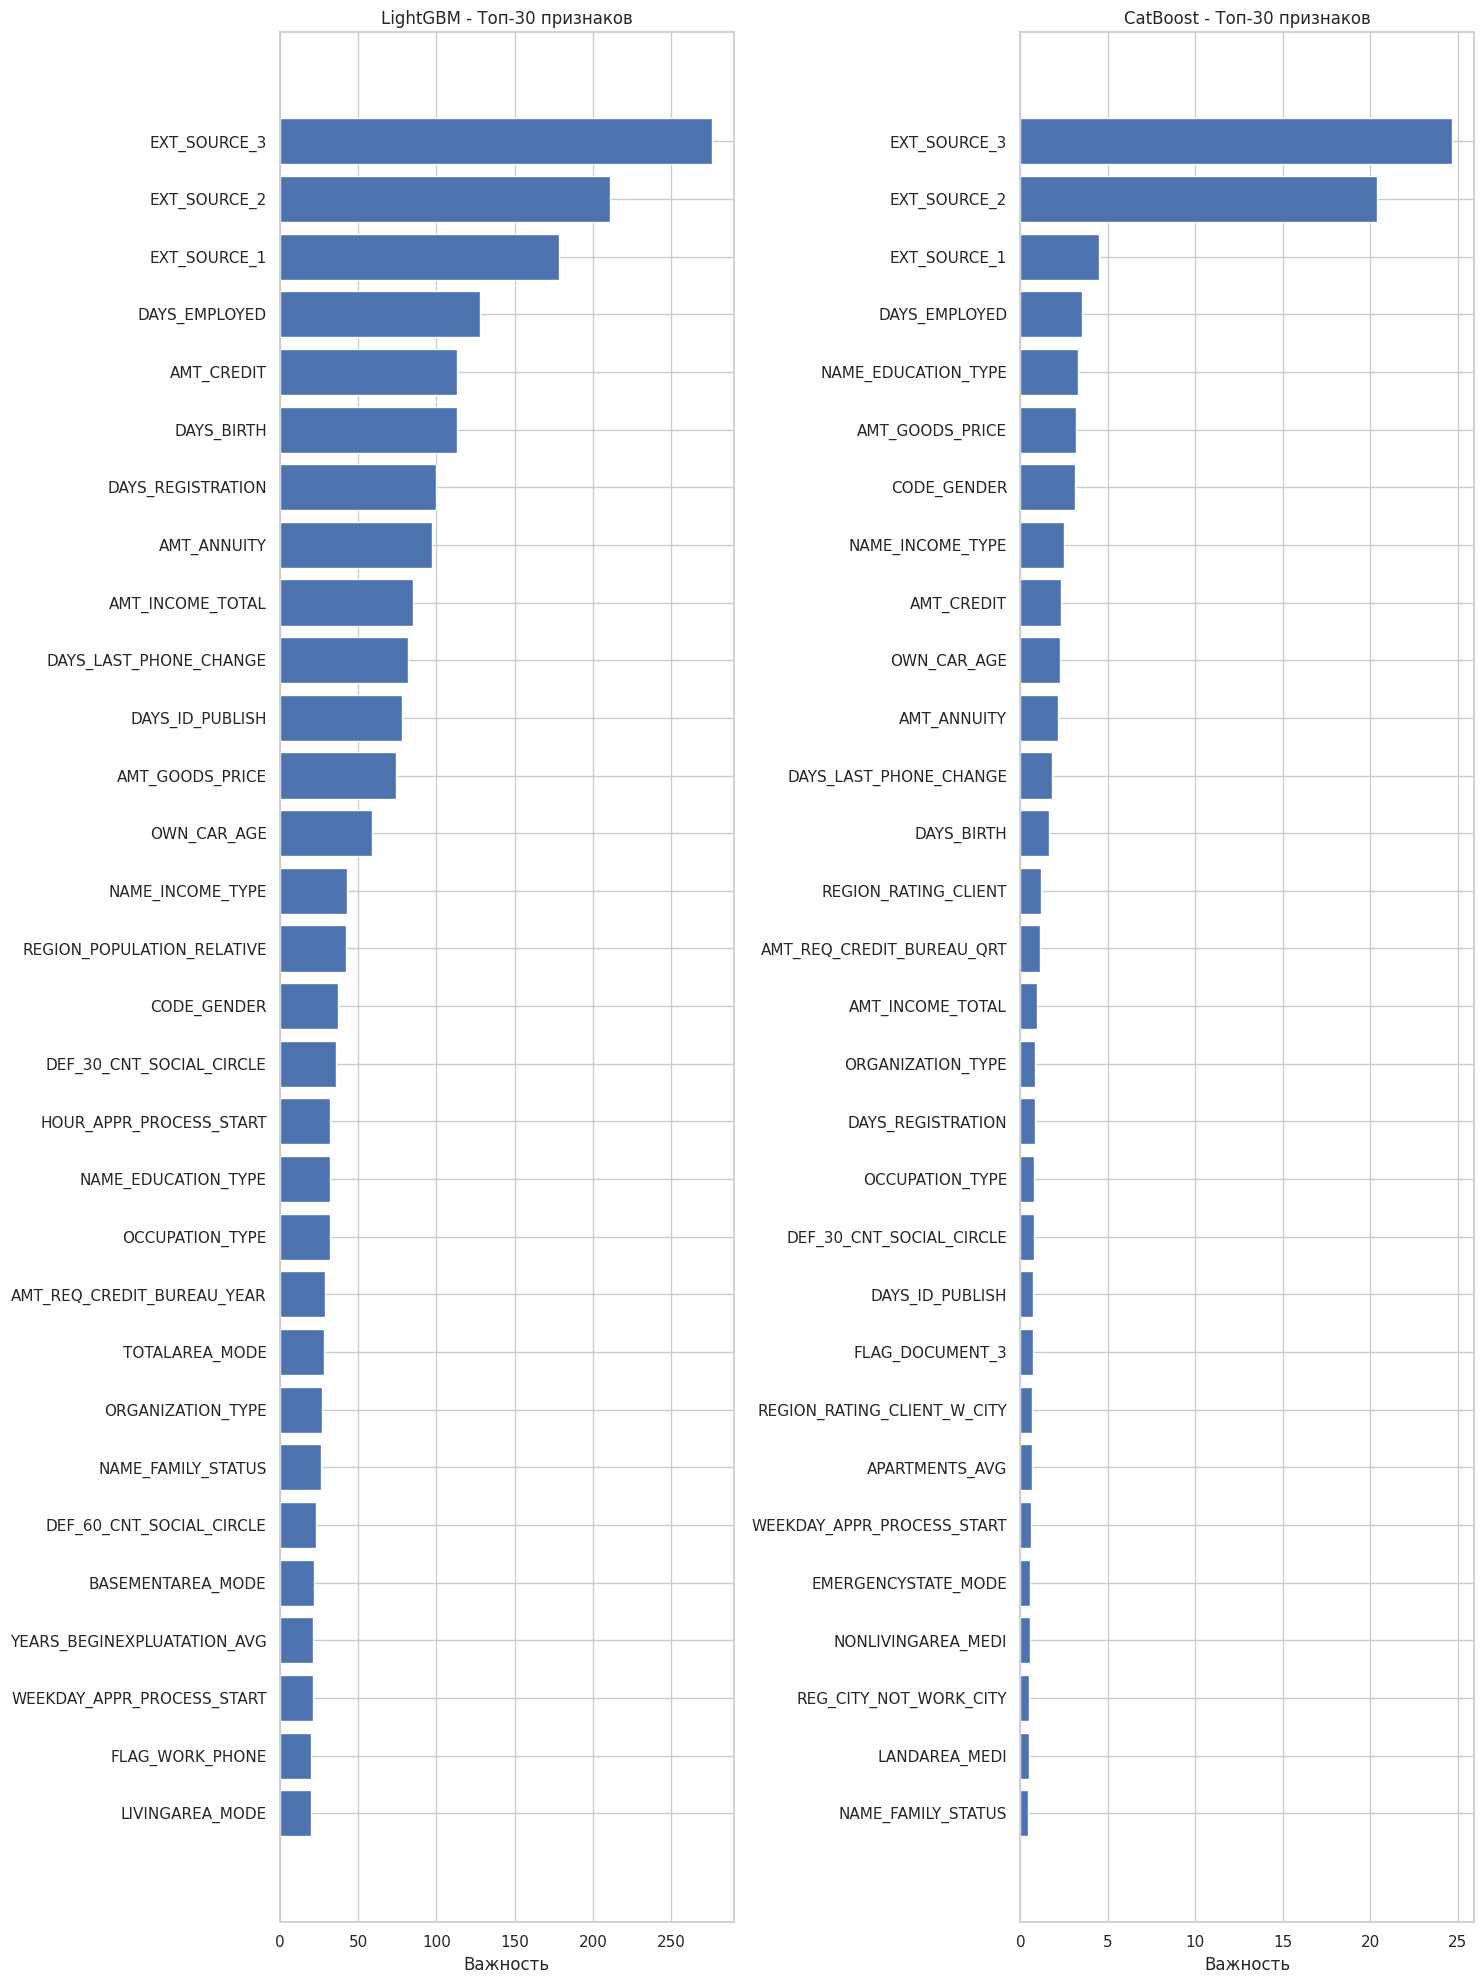

LightGBM: 22 важных признаков из 120
CatBoost: 8 важных признаков из 120

LightGBM:
  Признаков: 120 → 22
  PR-AUC: 0.2110 → 0.2089

CatBoost:
  Признаков: 120 → 8
  PR-AUC: 0.2084 → 0.2040


In [57]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Загрузка данных
df = pd.read_csv('/content/application_train.csv')
y = df['TARGET'].copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET']).sample(n=50000, random_state=0)
y = y.loc[X.index]

# Подготовка данных
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna('UNKNOWN')
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Оптимальные параметры
lgb_params = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'num_leaves': 50}
cat_params = {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100}

# Обучение моделей
lgb_model = lgb.LGBMClassifier(**lgb_params, random_state=0, verbose=-1, n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]
lgb_pr_auc = average_precision_score(y_test, lgb_preds)

cat_model = cb.CatBoostClassifier(**cat_params, random_state=0, verbose=False)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict_proba(X_test)[:, 1]
cat_pr_auc = average_precision_score(y_test, cat_preds)

print(f"LightGBM PR-AUC: {lgb_pr_auc:.4f}")
print(f"CatBoost PR-AUC: {cat_pr_auc:.4f}")

# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(15, 20))

# LightGBM
lgb_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[0].barh(lgb_importances['feature'].tail(30), lgb_importances['importance'].tail(30))
axes[0].set_xlabel('Важность')
axes[0].set_title('LightGBM - Топ-30 признаков')

# CatBoost
cat_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance()
}).sort_values('importance', ascending=True)

axes[1].barh(cat_importances['feature'].tail(30), cat_importances['importance'].tail(30))
axes[1].set_xlabel('Важность')
axes[1].set_title('CatBoost - Топ-30 признаков')

plt.tight_layout()
plt.show()

# Определение порогов и отбор признаков
lgb_threshold = lgb_importances['importance'].max() * 0.1
important_features_lgb = lgb_importances[lgb_importances['importance'] >= lgb_threshold]['feature'].tolist()

cat_threshold = cat_importances['importance'].max() * 0.1
important_features_cat = cat_importances[cat_importances['importance'] >= cat_threshold]['feature'].tolist()

print(f"LightGBM: {len(important_features_lgb)} важных признаков из {len(X.columns)}")
print(f"CatBoost: {len(important_features_cat)} важных признаков из {len(X.columns)}")

# Обучение на отобранных признаках
X_train_lgb_sel = X_train[important_features_lgb]
X_test_lgb_sel = X_test[important_features_lgb]

lgb_model_sel = lgb.LGBMClassifier(**lgb_params, random_state=0, verbose=-1, n_jobs=-1)
lgb_model_sel.fit(X_train_lgb_sel, y_train)
lgb_preds_sel = lgb_model_sel.predict_proba(X_test_lgb_sel)[:, 1]
lgb_pr_auc_sel = average_precision_score(y_test, lgb_preds_sel)

X_train_cat_sel = X_train[important_features_cat]
X_test_cat_sel = X_test[important_features_cat]

cat_model_sel = cb.CatBoostClassifier(**cat_params, random_state=0, verbose=False)
cat_model_sel.fit(X_train_cat_sel, y_train)
cat_preds_sel = cat_model_sel.predict_proba(X_test_cat_sel)[:, 1]
cat_pr_auc_sel = average_precision_score(y_test, cat_preds_sel)

# Сравнение
print(f"\nLightGBM:")
print(f"  Признаков: {X_train.shape[1]} → {X_train_lgb_sel.shape[1]}")
print(f"  PR-AUC: {lgb_pr_auc:.4f} → {lgb_pr_auc_sel:.4f}")

print(f"\nCatBoost:")
print(f"  Признаков: {X_train.shape[1]} → {X_train_cat_sel.shape[1]}")
print(f"  PR-AUC: {cat_pr_auc:.4f} → {cat_pr_auc_sel:.4f}")